In [444]:
# importing all required libraries
import pandas as pd
import numpy as np

import datetime as dt

# importing plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import seaborn as sns

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#Import the plotly libraries
import plotly.express as px

In [445]:
# set it to convert float values to 2 decimals
pd.options.display.float_format = '{:.2f}'.format 

# Importing data files

In [446]:
# import loan file using pandas

loan = pd.read_csv('./loan.csv')

# saving to temp
temp = loan

### check shape & datatype of loan data

In [447]:
# checking shape of dataframe
print('shape: ', loan.shape)
print('')

# checking info of dataframe
print('info: ', loan.info())
print()

# checking data types of dataframe
print('DataTypes: ', loan.dtypes)

shape:  (39717, 111)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB
info:  None

DataTypes:  id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object


In [448]:
# storing all column names in a np array for future uses
all_col=np.array(loan.columns)

## Cleaning Dataset

### checking for duplicate id's

In [449]:
# using duplicated method to check if there are any duplicates
print(loan.duplicated(['id']).count())
loan_dup=loan[loan.duplicated(['id'])]
print(loan_dup.shape)

39717
(0, 111)


In [450]:
# as we can see there are not duplicate entries ,so we can proceed further

#### checking for null entries

In [451]:
# checking for all columns null
loan.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [452]:
# there seems to be many columns which are all nulls.
# removing columns which are all nulls

In [453]:
# getting columns which are all nulls as list
null_col = np.array(loan.columns[loan.isnull().all()])

In [454]:
# dropping all null columns
loan.drop(null_col, axis=1, inplace=True)

In [455]:
# Also, we don't require columns other than these for our analysis
needed_cols = np.array(['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','grade','sub_grade','emp_length',
              'home_ownership','annual_inc','verification_status','issue_d','loan_status','purpose','zip_code','addr_state','dti','total_pymnt',
               'recoveries','policy_code','application_type'])

In [456]:
# getting all other columsn to remove
non_needed_cols = list(np.setdiff1d(all_col, needed_cols))

In [457]:
# dropping all non-required columns
loan.drop(non_needed_cols, axis=1, inplace=True, errors='ignore')

In [458]:
# also, we don't need current loan_status rows as they are currently repaying the loans
loan = loan[loan.loan_status != 'Current']

#### check if nulls still present

In [459]:
100 * (loan.isnull().sum()/len(loan.index))

id                    0.00
loan_amnt             0.00
funded_amnt           0.00
funded_amnt_inv       0.00
term                  0.00
int_rate              0.00
installment           0.00
grade                 0.00
sub_grade             0.00
emp_length            2.68
home_ownership        0.00
annual_inc            0.00
verification_status   0.00
issue_d               0.00
loan_status           0.00
purpose               0.00
zip_code              0.00
addr_state            0.00
dti                   0.00
total_pymnt           0.00
recoveries            0.00
policy_code           0.00
application_type      0.00
dtype: float64

In [460]:
# we can see there are nulls only in emp length and it's arround 2.68%
# let's dorp those rows to have accurate data
loan = loan[~loan.emp_length.isnull()]

In [461]:
100 * (loan.isnull().sum()/len(loan.index))

id                    0.00
loan_amnt             0.00
funded_amnt           0.00
funded_amnt_inv       0.00
term                  0.00
int_rate              0.00
installment           0.00
grade                 0.00
sub_grade             0.00
emp_length            0.00
home_ownership        0.00
annual_inc            0.00
verification_status   0.00
issue_d               0.00
loan_status           0.00
purpose               0.00
zip_code              0.00
addr_state            0.00
dti                   0.00
total_pymnt           0.00
recoveries            0.00
policy_code           0.00
application_type      0.00
dtype: float64

#### Now data set doesn't have any null values

In [462]:
# storing this data into backup
laon_bck = loan

### Conversion and creating columns based on the exisitng columns

In [463]:
loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,issue_d,loan_status,purpose,zip_code,addr_state,dti,total_pymnt,recoveries,policy_code,application_type
0,1077501,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,10+ years,...,Dec-11,Fully Paid,credit_card,860xx,AZ,27.65,5863.16,0.00,1,INDIVIDUAL
1,1077430,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,< 1 year,...,Dec-11,Charged Off,car,309xx,GA,1.00,1008.71,117.08,1,INDIVIDUAL
2,1077175,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,10+ years,...,Dec-11,Fully Paid,small_business,606xx,IL,8.72,3005.67,0.00,1,INDIVIDUAL
3,1076863,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,10+ years,...,Dec-11,Fully Paid,other,917xx,CA,20.00,12231.89,0.00,1,INDIVIDUAL
5,1075269,5000,5000,5000.00,36 months,7.90%,156.46,A,A4,3 years,...,Dec-11,Fully Paid,wedding,852xx,AZ,11.20,5632.21,0.00,1,INDIVIDUAL


In [464]:
loan.dtypes

id                       int64
loan_amnt                int64
funded_amnt              int64
funded_amnt_inv        float64
term                    object
int_rate                object
installment            float64
grade                   object
sub_grade               object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
issue_d                 object
loan_status             object
purpose                 object
zip_code                object
addr_state              object
dti                    float64
total_pymnt            float64
recoveries             float64
policy_code              int64
application_type        object
dtype: object

In [465]:
# looks like term is object type.
# let's change it to int
loan.term = loan.term.apply(lambda x: int(x.split(' ')[1]))

In [466]:
# looks like int_rate is object type.
# let's change it to int
loan.int_rate = loan.int_rate.apply(lambda x: float(x.split('%')[0]))

In [467]:
# let's create column to store zip_code as int with xx
# eg: 245XX -> 245 
loan.zip_code = loan.zip_code.apply(lambda x: int(x.replace('xx','')))

In [468]:
# let's convert issue_d to data and month columns
loan['issue_month'] = loan.issue_d.apply(lambda x: dt.datetime.strptime(x,'%b-%y').date().month)
loan['issue_year'] = loan.issue_d.apply(lambda x: dt.datetime.strptime(x,'%b-%y').date().year)

In [469]:
# let's convert loan_status to 1's and 0's
# where 1 = 'Fully Paid' and 0 = 'Charged Off'
loan['loan_status_bit'] = loan.loan_status.apply(lambda x: 1 if x=='Fully Paid' else 0)

In [470]:
# replacing '_' with ' ' in purpose of loan string
loan.purpose = loan.purpose.apply(lambda x: x.replace('_', ' '))

In [471]:
# Creating a basic profit and loss column
loan['pl']=(loan['total_pymnt']-loan['funded_amnt'])*100/loan['funded_amnt']

In [472]:
loan.dtypes

id                       int64
loan_amnt                int64
funded_amnt              int64
funded_amnt_inv        float64
term                     int64
int_rate               float64
installment            float64
grade                   object
sub_grade               object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
issue_d                 object
loan_status             object
purpose                 object
zip_code                 int64
addr_state              object
dti                    float64
total_pymnt            float64
recoveries             float64
policy_code              int64
application_type        object
issue_month              int64
issue_year               int64
loan_status_bit          int64
pl                     float64
dtype: object

##### It seems the data and their types are as required for analysis

##### storing backup of cleaned data

In [473]:
# storing back after cleaning
loan_back_cleaned = loan

#### Outliers removal

In [474]:
# removing outliers of annual income grator than 99%

loan = loan[loan.annual_inc < loan.annual_inc.quantile(0.99)]

In [475]:
# remaining outliers are ok to proceed for analysis

# Analysis

#### Basic Analysis

In [476]:
# let's look at loan_status and loan_amt
# here 1 - Fully paid and 0 - charged off
print(loan.loan_status.value_counts())
100*(loan.loan_status.value_counts()/len(loan.index))

Fully Paid     31808
Charged Off     5357
Name: loan_status, dtype: int64


Fully Paid    85.59
Charged Off   14.41
Name: loan_status, dtype: float64

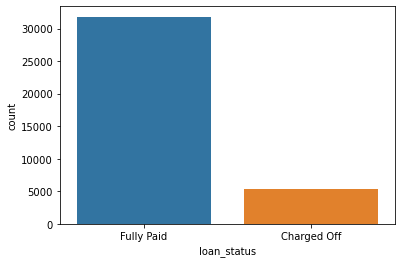

In [477]:
sns.countplot(x= loan.loan_status)
plt.show()

# here  1 - Fully Paid
#       0 - Charged Off

___About 85% of applications are Fully paid compared to 15% of charged off___

In [478]:
# Let's see basic statistics with describe() - Quantitative Variables
loan.loan_amnt.describe()

count   37165.00
mean    11032.38
std      7270.30
min       500.00
25%      5400.00
50%      9800.00
75%     15000.00
max     35000.00
Name: loan_amnt, dtype: float64

In [479]:
# also, let's take a look at the basic statistics of total payments
loan.total_pymnt.describe()

count   37165.00
mean    11854.17
std      8708.45
min         0.00
25%      5551.27
50%      9719.06
75%     16089.68
max     58563.68
Name: total_pymnt, dtype: float64

In [480]:
# also, let's take a look at the basic statistics of annual_inc
loan.annual_inc.describe()

count    37165.00
mean     65903.07
std      35153.36
min       4000.00
25%      40906.00
50%      59000.00
75%      81600.00
max     234996.00
Name: annual_inc, dtype: float64

In [481]:
# let's take a look at interest rate
loan.int_rate.describe()

count   37165.00
mean       11.95
std         3.68
min         5.42
25%         8.94
50%        11.83
75%        14.35
max        24.40
Name: int_rate, dtype: float64

In [586]:
# basic analysis of DTI
loan.dti.describe()

count   37165.00
mean       13.35
std         6.65
min         0.00
25%         8.24
50%        13.45
75%        18.60
max        29.99
Name: dti, dtype: float64

### Univariate Analysis

In [482]:
loan.annual_inc.describe()

count    37165.00
mean     65903.07
std      35153.36
min       4000.00
25%      40906.00
50%      59000.00
75%      81600.00
max     234996.00
Name: annual_inc, dtype: float64

[Text(0.5, 0, '')]

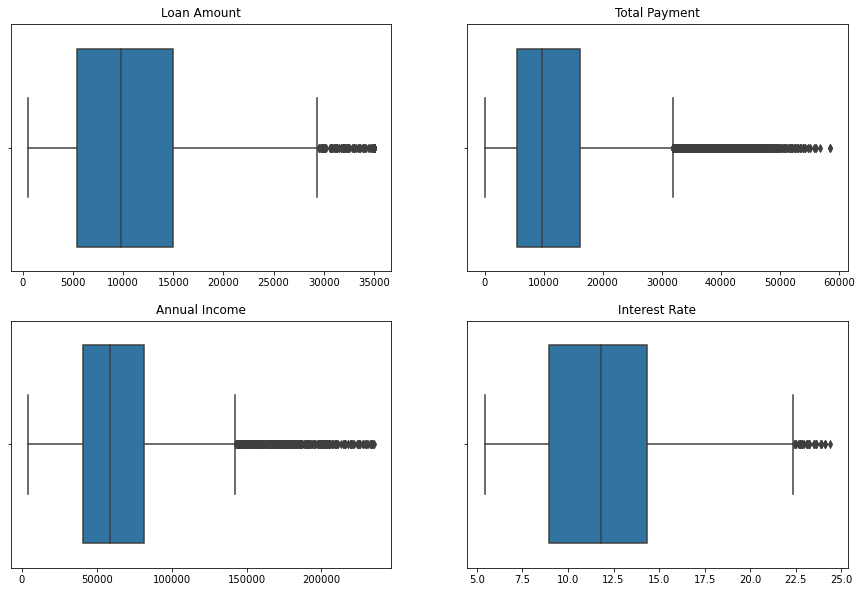

In [483]:
plt.figure(figsize=(15,10))

# box plot for loan amount
plt.subplot(2,2,1)
plt.title('Loan Amount', pad=7)
g1 = sns.boxplot(loan.loan_amnt)
g1.set(xlabel=None)

# box plot for total payment
plt.subplot(2,2,2)
plt.title('Total Payment', pad=7)
g2 = sns.boxplot(loan.total_pymnt)
g2.set(xlabel=None)

# box plot for Anual income
plt.subplot(2,2,3)
plt.title('Annual Income', pad=7)
g3 = sns.boxplot(loan.annual_inc)
g3.set(xlabel=None)

# box plot for Interest rate
plt.subplot(2,2,4)
plt.title('Interest Rate', pad=7)
g4 = sns.boxplot(loan.int_rate)
g4.set(xlabel=None)

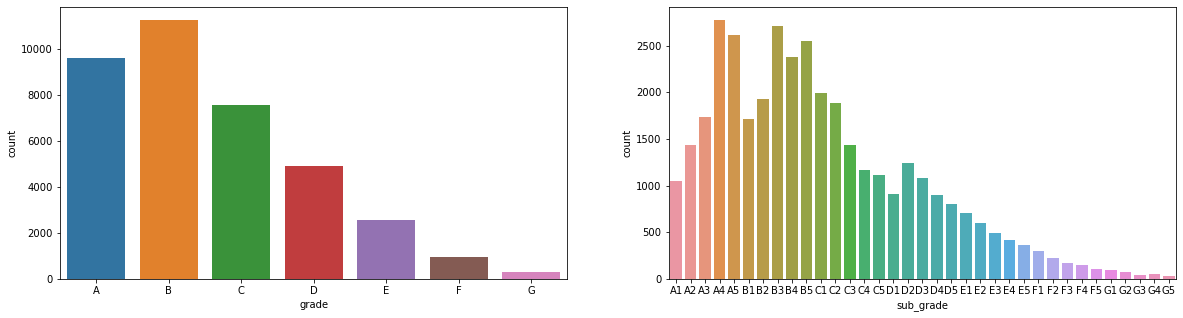

In [495]:
# counts as bar plot for grade and sub-grade

plt.figure(figsize=(20, 5))

grade_order = ['A', 'B', 'C', 'D' ,'E', 'F', 'G']
sub_grade_order = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 
                   'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 
                   'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 
                   'G1', 'G2', 'G3', 'G4', 'G5']

plt.subplot(1,2,1)
sns.countplot(x='grade', data=loan, order=grade_order)

plt.subplot(1,2,2)
sns.countplot(x='sub_grade', data=loan, order=sub_grade_order)
plt.show()

__Most loans have grade A or B__
<br>
__Among A - A4 & A5 and Among B - B3 & B5 are given most loans__

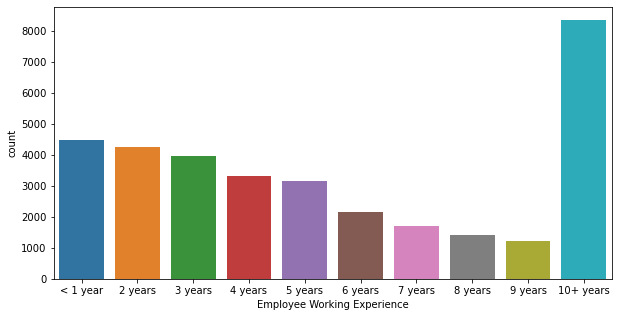

In [516]:
# bar plot of employees count with experience

plt.figure(figsize=(10, 5))

emp_len_order = ['< 1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

sns.countplot(x='emp_length', data=loan, order=emp_len_order)
plt.xlabel('Employee Working Experience')
plt.show()

__Most of the loans are taken by 10+years of exp people__

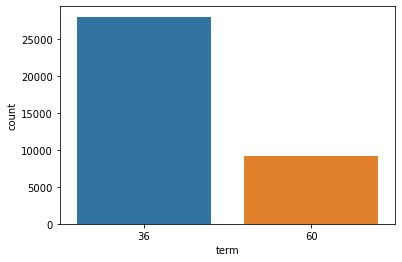

In [517]:
# bar plot of loan counts based on term

sns.countplot(x='term', data=loan)
plt.show()

__Here, Most people opted for 36 years compared to 60 years of term plans__

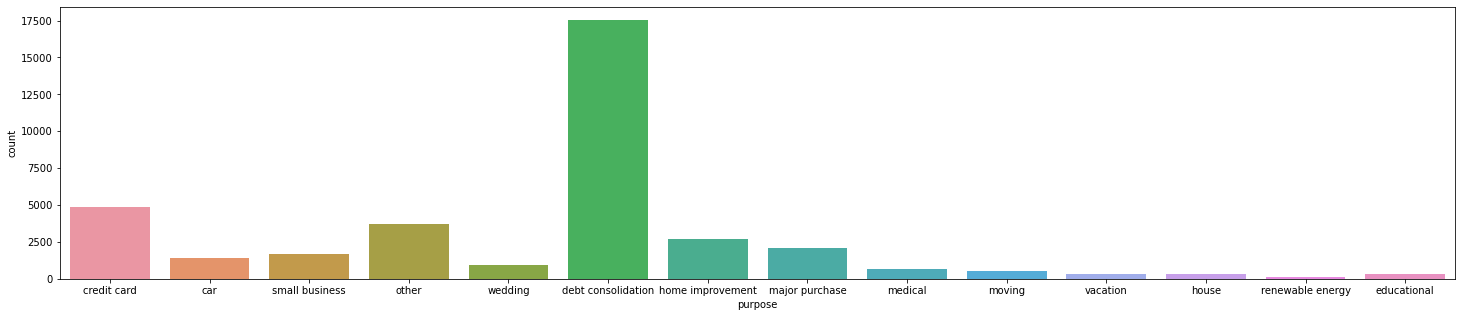

In [487]:
# bar plot for counts based on purpose of loan

plt.figure(figsize=(25, 5))

sns.countplot(x='purpose', data=loan)
plt.show()

__Most people took loans for 'Debt consolidation' and then followed by 'Credit Cards' and 'Other'__

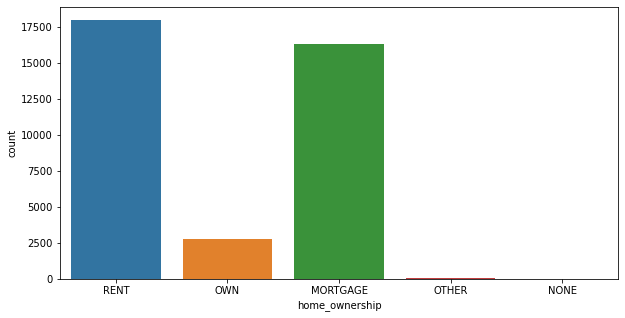

In [488]:
# bar plot for counts based on home ownership

plt.figure(figsize=(10, 5))

sns.countplot(x='home_ownership', data=loan)
plt.show()

__Most loans are taken by people who are on 'RENT' followed by 'MORTGAGE'__

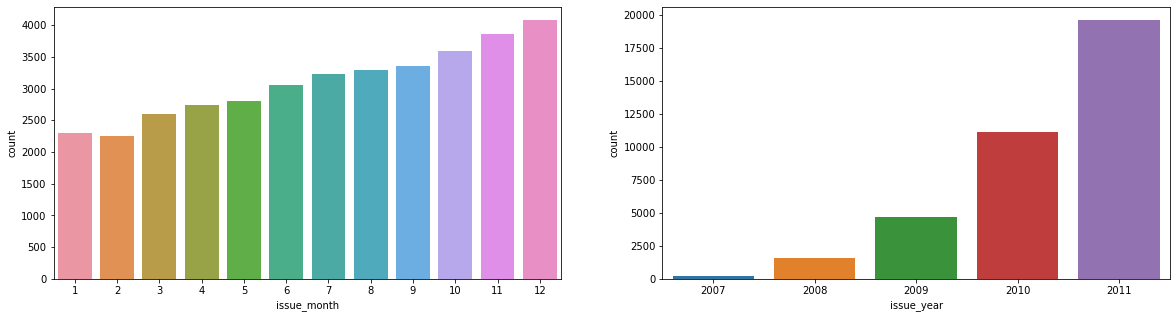

In [489]:
# bar plots for loan issue dates

plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
sns.countplot(x='issue_month', data=loan)

plt.subplot(1,2,2)
sns.countplot(x='issue_year', data=loan)
plt.show()

__Most loans are taken around 'December' as it is holiday season and trend increases year on year__

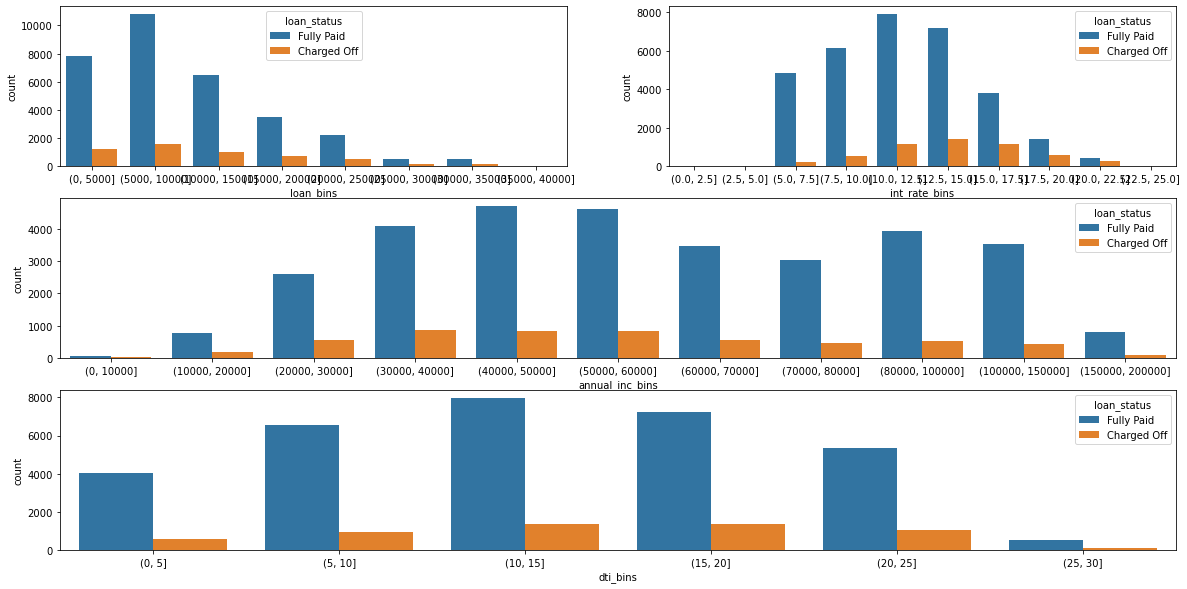

In [593]:
# plot of loan_amnt, int_rate, annual_inc binning 

plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 2)

cut_loan_bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
loan['loan_bins'] = pd.cut(loan['loan_amnt'], bins=cut_loan_bins)

cut_int_bins = [0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,25]
loan['int_rate_bins'] = pd.cut(loan.int_rate, bins=cut_int_bins)

cut_ann_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 100000, 150000, 200000]
loan['annual_inc_bins'] = pd.cut(loan.annual_inc, bins=cut_ann_bins)

cut_dti_bins = [0, 5, 10, 15, 20, 25, 30]
loan['dti_bins'] = pd.cut(loan.dti, bins=cut_dti_bins)

plt.subplot(gs[0,0])
sns.countplot(x='loan_bins', hue='loan_status', data=loan)

plt.subplot(gs[0,1])
sns.countplot(x='int_rate_bins', hue='loan_status', data=loan)

plt.subplot(gs[1,:])
sns.countplot(x='annual_inc_bins', hue='loan_status', data=loan)

plt.subplot(gs[2,:])
sns.countplot(x='dti_bins', hue='loan_status', data=loan)


plt.show()


## Correlation

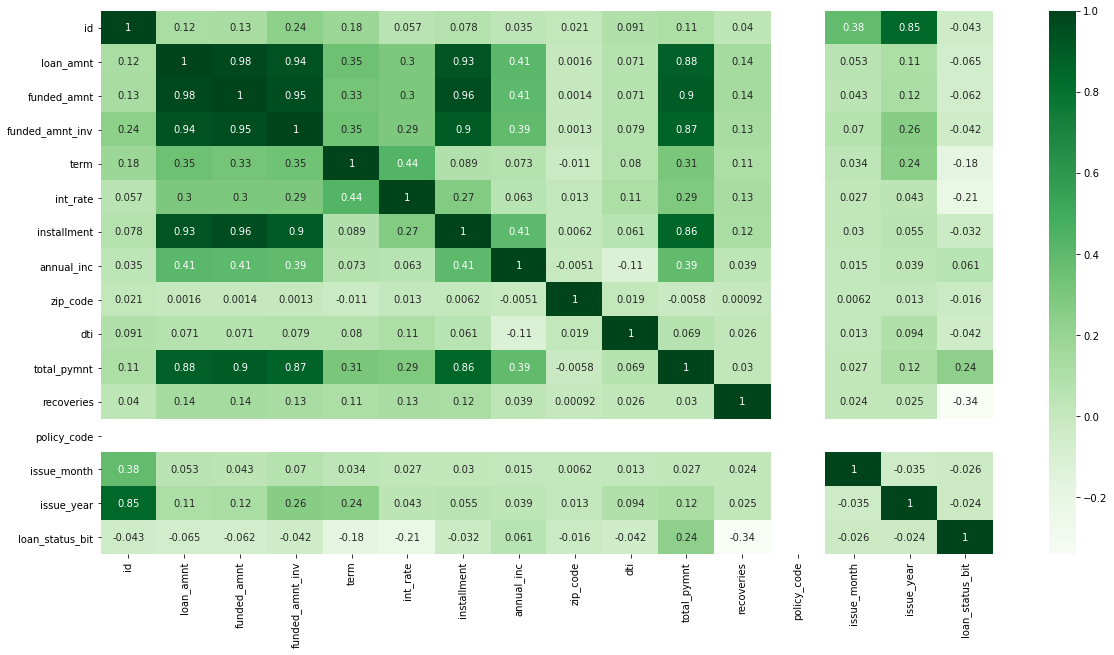

In [439]:
plt.figure(figsize=(20, 10))

loan_corr = loan.corr()
sns.heatmap(loan_corr, cmap = "Greens", annot=True)
plt.show()

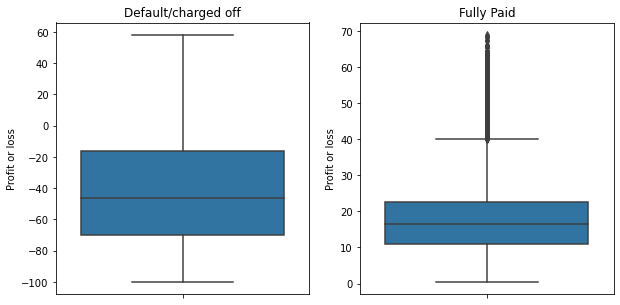

In [512]:
# relationship of Funded Amount with defaults
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Default/charged off')
sns.boxplot(y=loan[loan.loan_status_bit==0].pl)
plt.ylabel('Profit or loss')

plt.subplot(1,2,2)
plt.title('Fully Paid')
sns.boxplot(y=loan[loan.loan_status_bit==1].pl)
plt.ylabel('Profit or loss')

plt.show()

### Relationships

In [651]:
# creating a function for plotting par plots with hue as loan status -- fully paid/charged off
def bar_plot(x_var, x_label, y_var, y_label, fig_size, inverse = False):
    plt.figure(figsize=fig_size)
    if inverse:
        sns.barplot(y=x_var, x=y_var, hue='loan_status', data=loan)
        plt.xlabel(y_label)
        plt.ylabel(x_label)
    else:
        sns.barplot(x=x_var, y=y_var, hue='loan_status', data=loan)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
    plt.show()

#### Loan amount & Loan Status vs.

In [654]:
# creating function with x-label as loan_bins
def bar_plot_loan_amt(x_var, x_label, fig_size=(10,4), inverse=False):
    bar_plot(x_var = x_var, x_label = x_label, y_var = 'loan_amnt', y_label = 'Loan Amount', inverse = inverse, fig_size = fig_size)

##### annual income

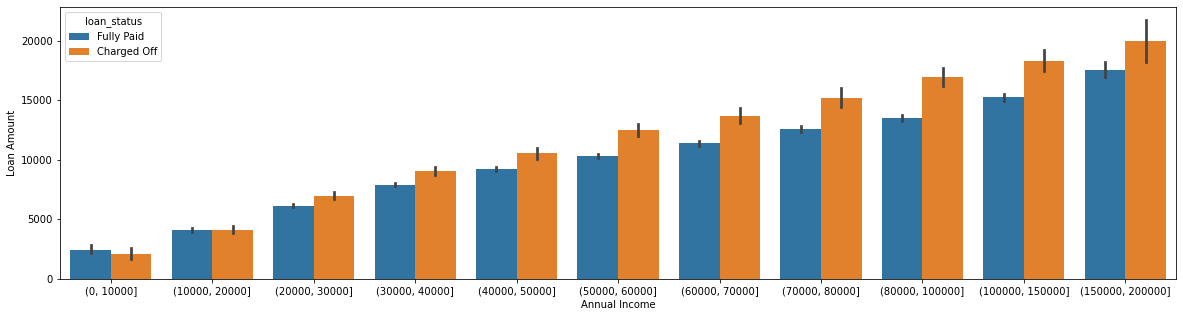

In [655]:
bar_plot_loan_amt('annual_inc_bins', 'Annual Income', (20,5))

##### term

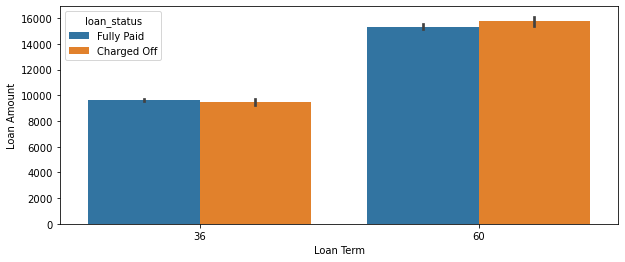

In [656]:
bar_plot_loan_amt('term','Loan Term')

##### Interest rate

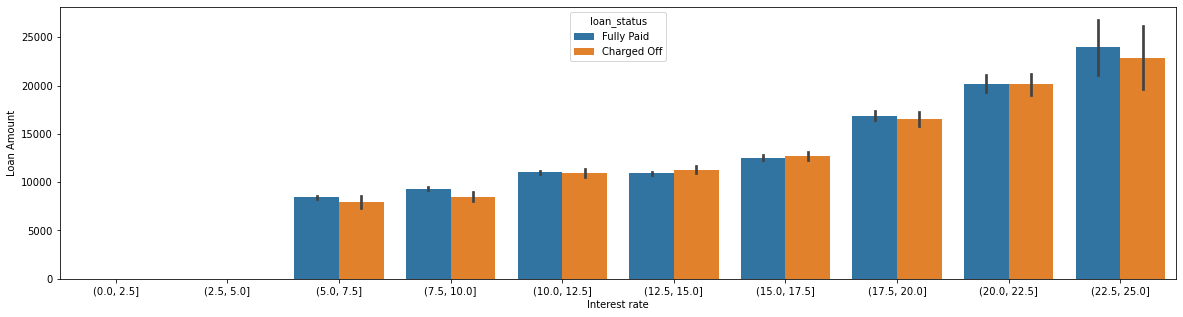

In [657]:
bar_plot_loan_amt('int_rate_bins','Interest rate', (20,5))

##### DTI

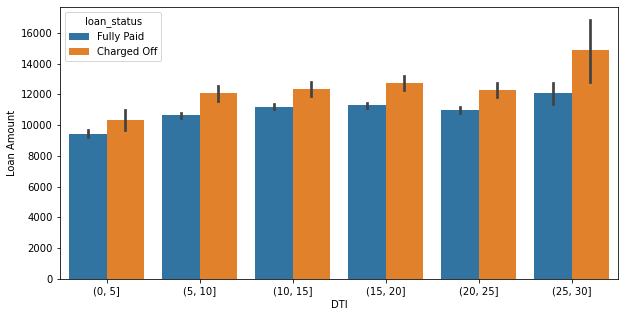

In [658]:
bar_plot_loan_amt('dti_bins','DTI', (10,5))

##### Issue year and month

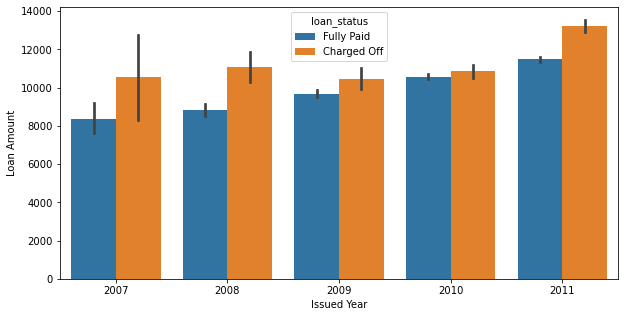

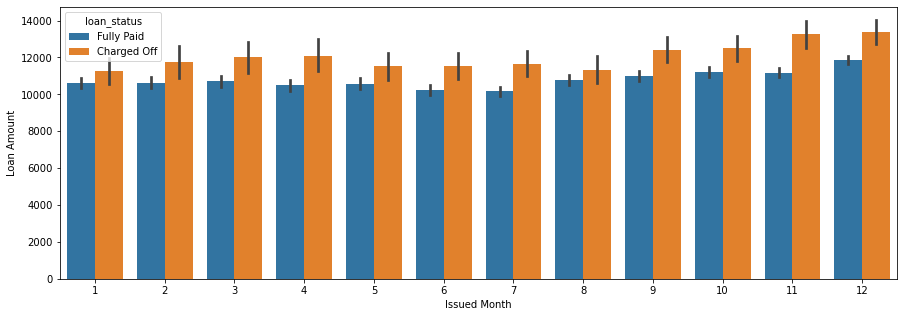

In [659]:
bar_plot_loan_amt('issue_year','Issued Year', (10,5))

bar_plot_loan_amt('issue_month','Issued Month', (15,5))

##### Area

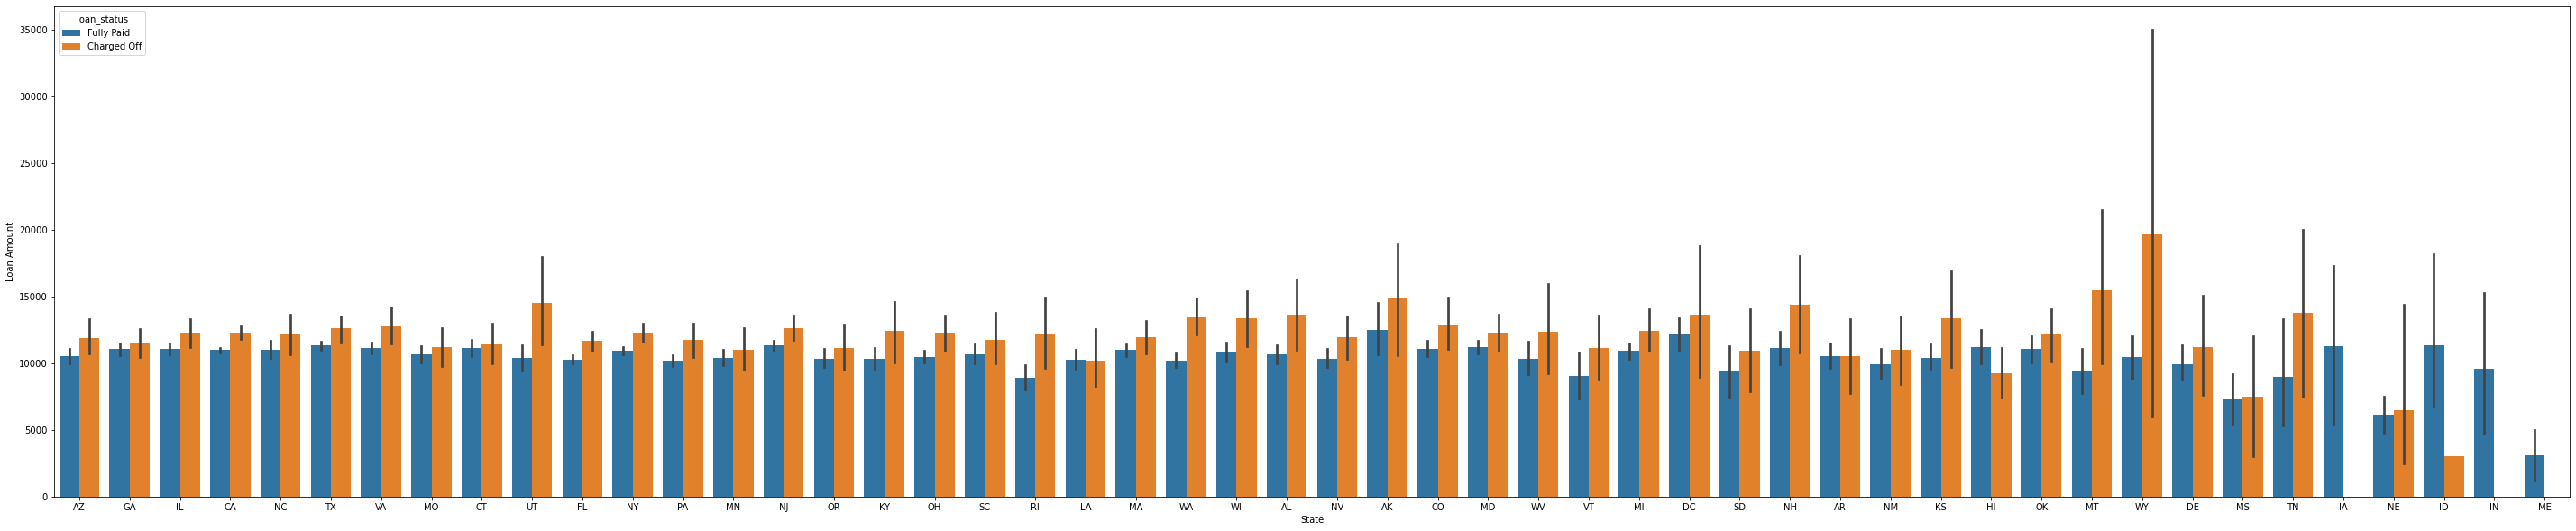

In [661]:
#loan.addr_state.value_counts()
bar_plot_loan_amt('addr_state','State', (50,10))

### Term & loan_status vs

In [662]:
# creating function with x-label as Term
def bar_plot_term(x_var, x_label, fig_size=(10,4), inverse=False):
    bar_plot(x_var = x_var, x_label = x_label, y_var = 'term', y_label = 'Term', inverse = inverse, fig_size = fig_size)

##### Interest rate

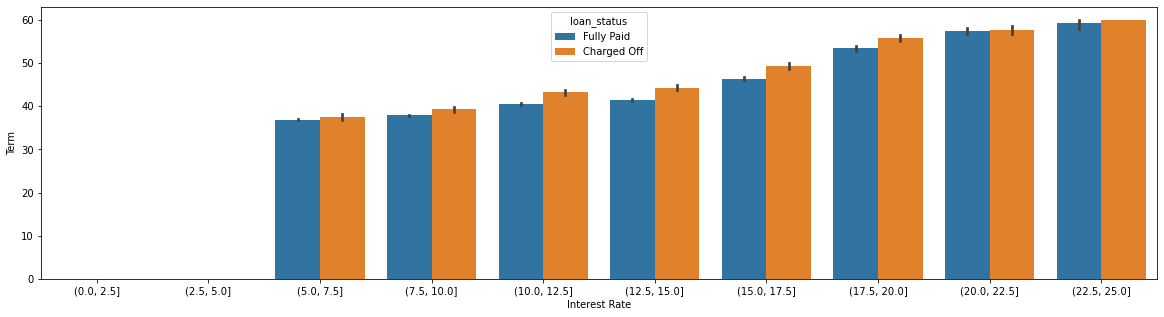

In [664]:
bar_plot_term('int_rate_bins', 'Interest Rate', (20,5))

##### Annual income

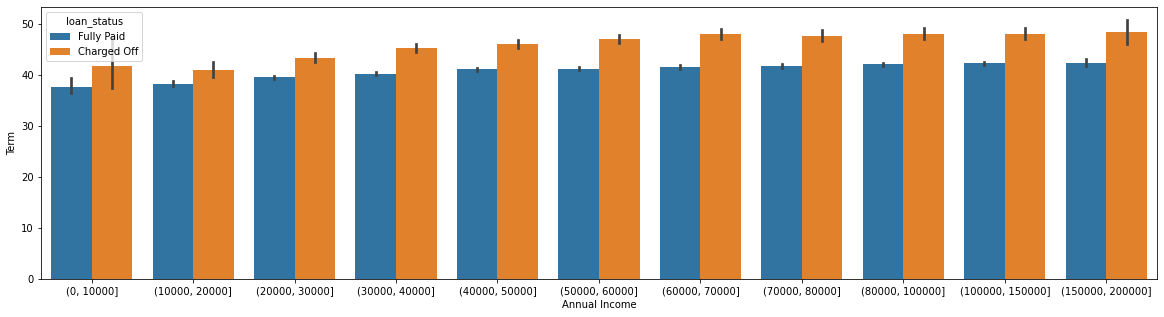

In [665]:
bar_plot_term('annual_inc_bins', 'Annual Income', (20,5))

##### DTI

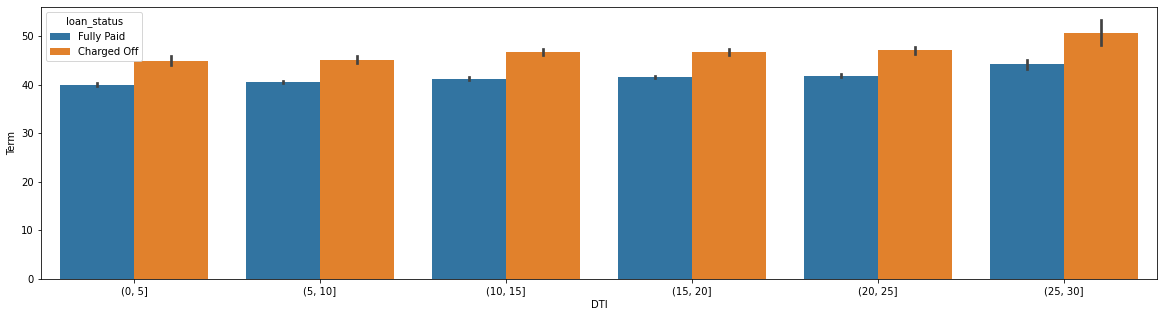

In [666]:
bar_plot_term('dti_bins', 'DTI', (20,5))

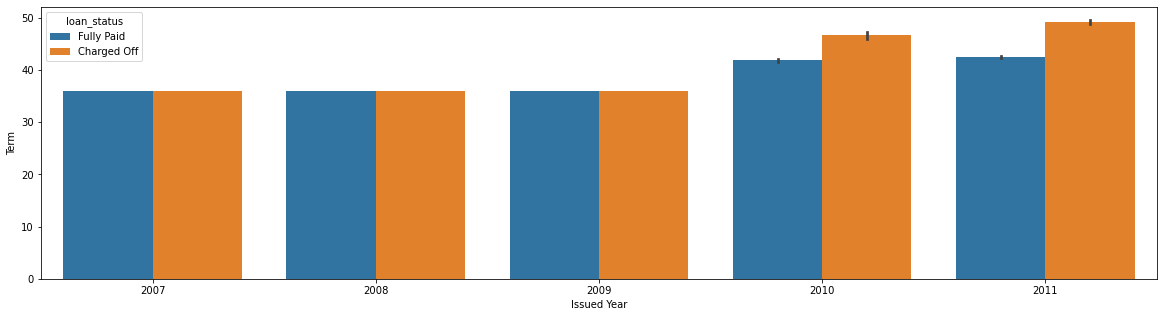

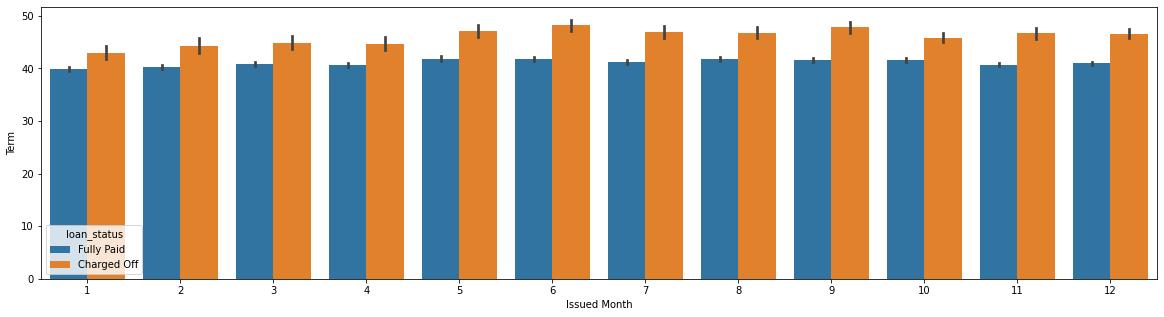

In [667]:
bar_plot_term('issue_year', 'Issued Year', (20,5))
bar_plot_term('issue_month', 'Issued Month', (20,5))

##### Area

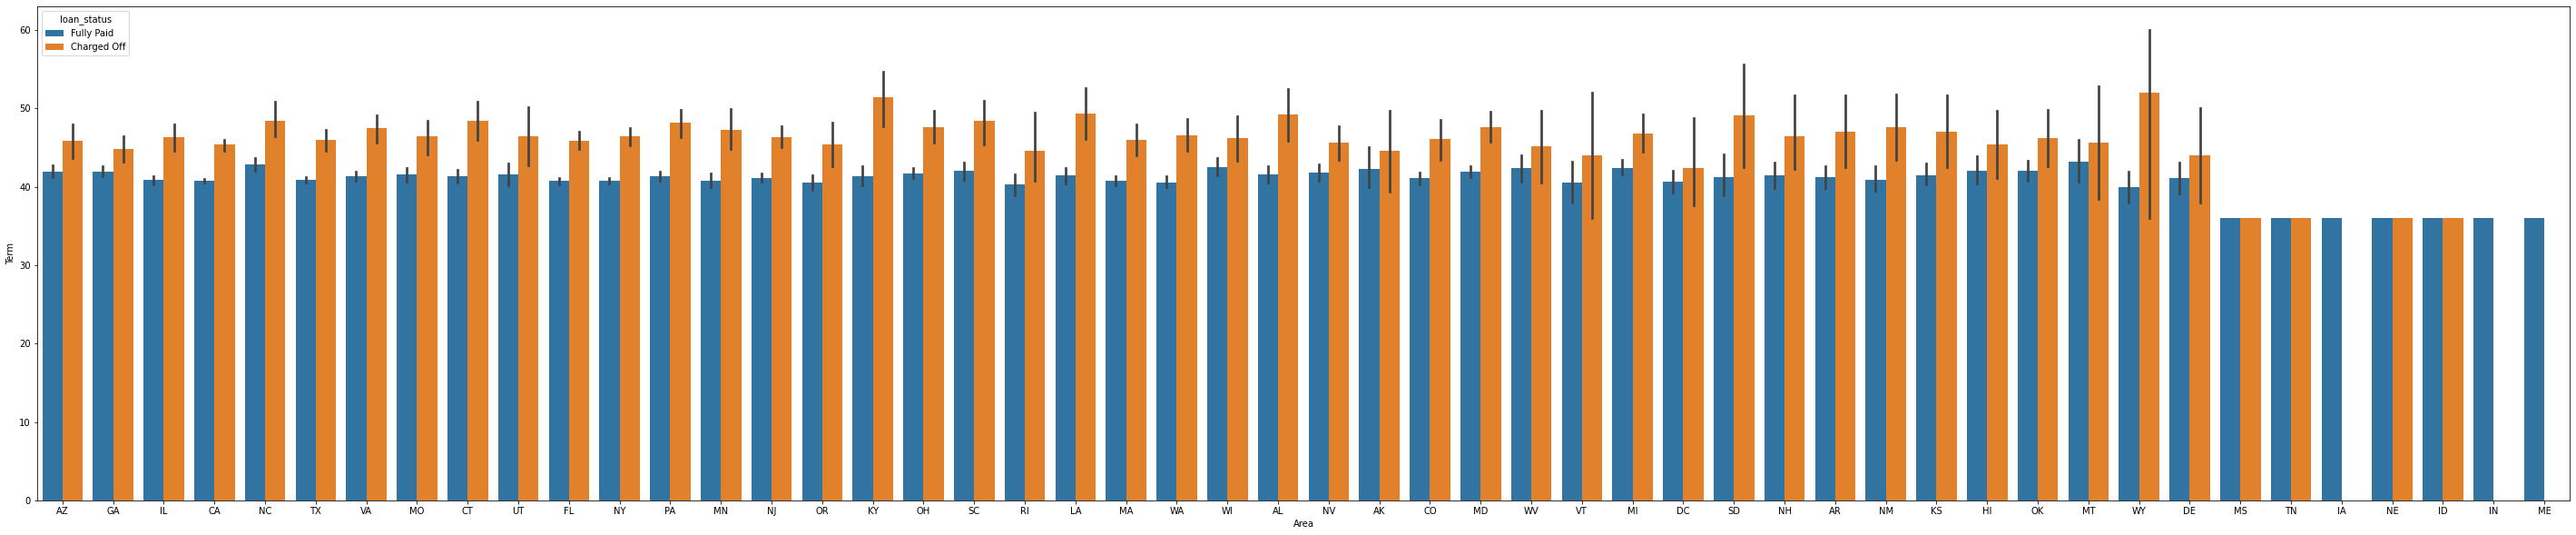

In [670]:
bar_plot_term('addr_state', 'Area', (50,10))

### Interest rate & Loan status Vs.

In [676]:
# creating function with x-label as interest rate
def bar_plot_int_rate(x_var, x_label, fig_size=(10,4), inverse=False):
    bar_plot(x_var = x_var, x_label = x_label, y_var = 'int_rate', y_label = 'Interest Rate', inverse = inverse, fig_size = fig_size)

##### DTI

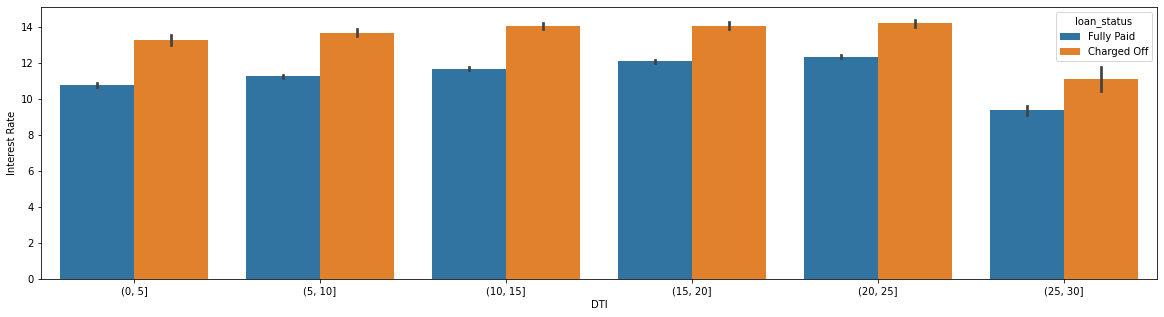

In [672]:
bar_plot_int_rate('dti_bins', 'DTI', (20,5))

##### Annual Income

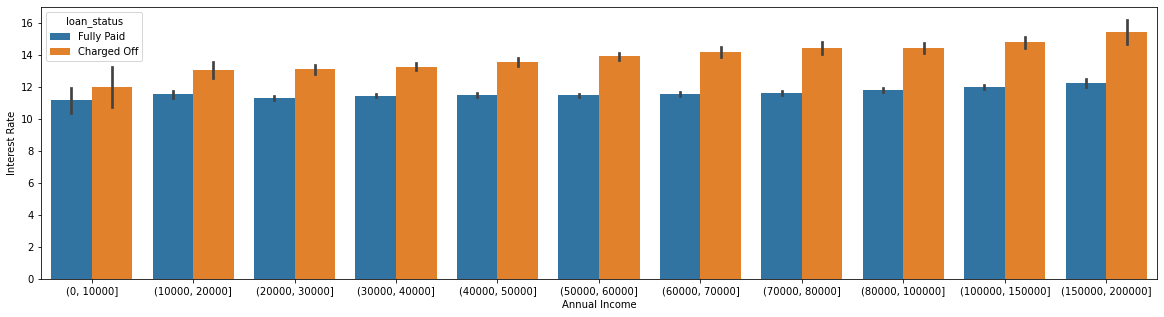

In [673]:
bar_plot_int_rate('annual_inc_bins', 'Annual Income', (20,5))

##### Issued Year and Issued Month

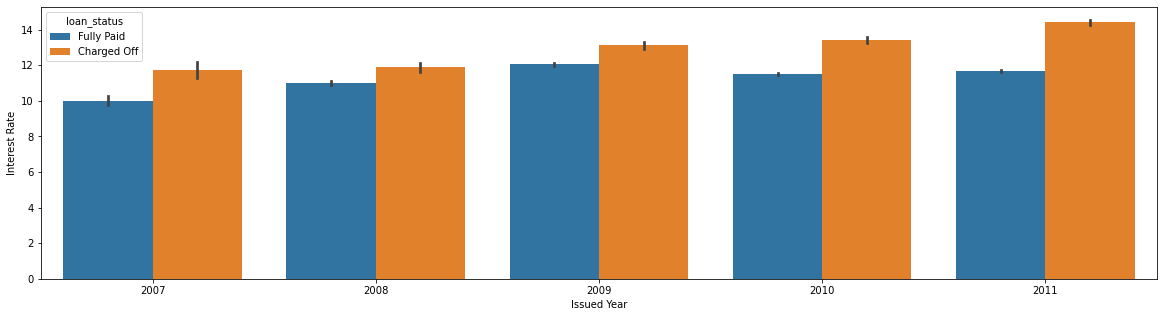

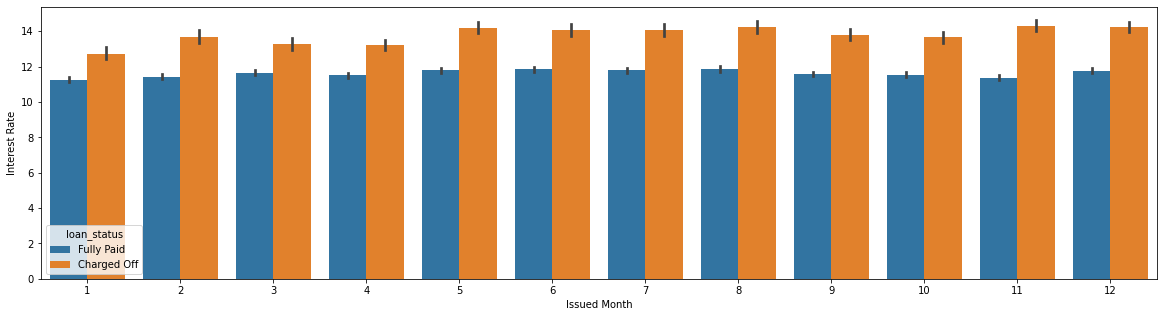

In [674]:
bar_plot_int_rate('issue_year', 'Issued Year', (20,5))
bar_plot_int_rate('issue_month', 'Issued Month', (20,5))

##### Area

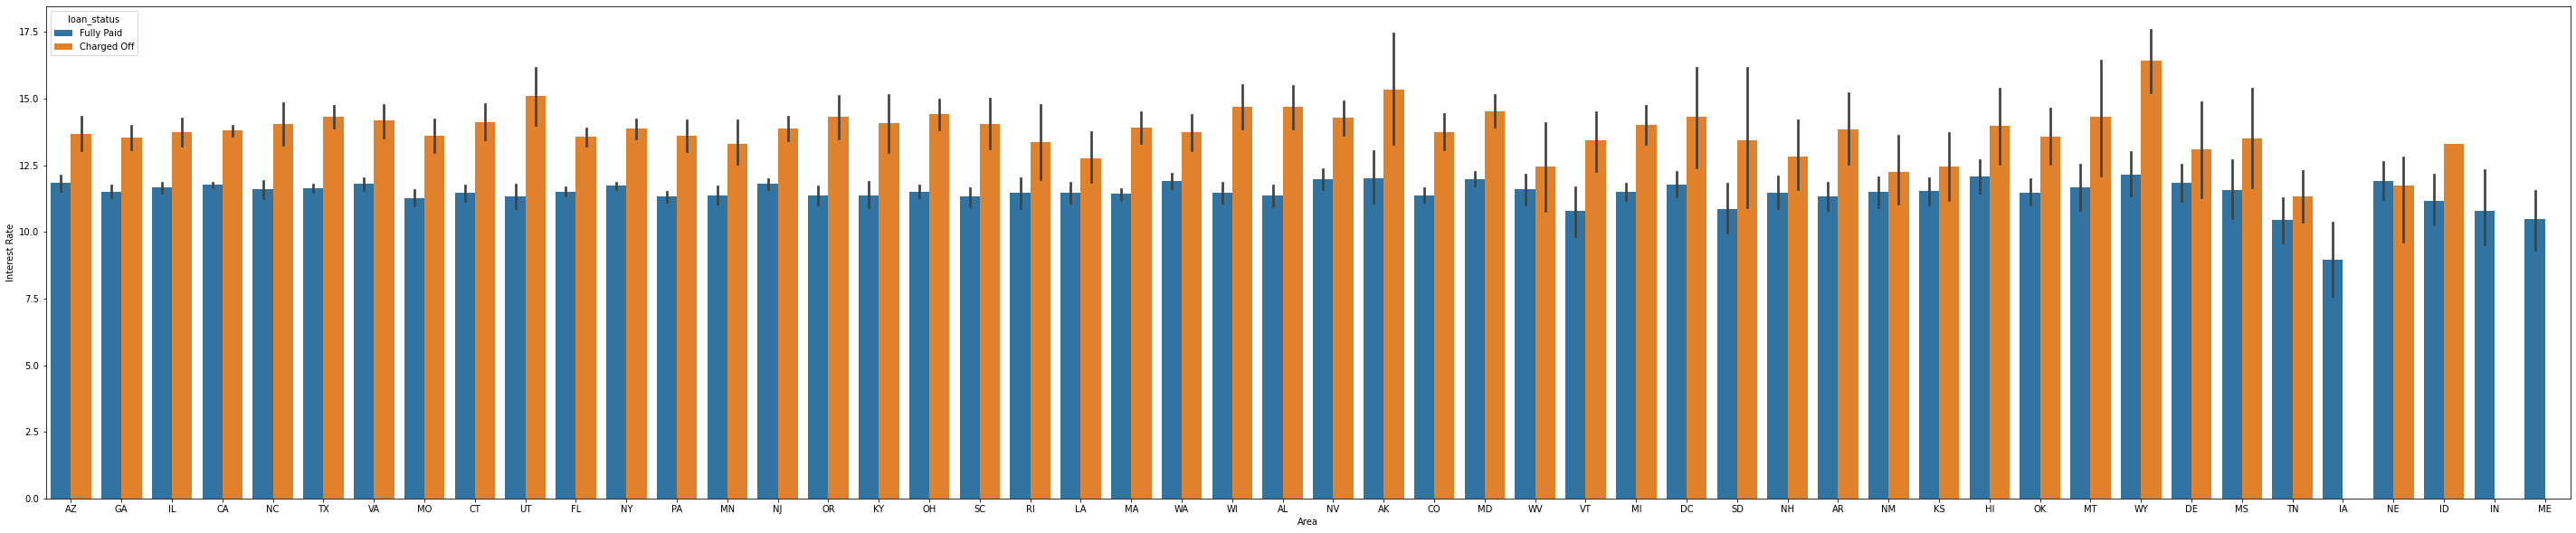

In [675]:
bar_plot_int_rate('addr_state', 'Area', (50,10))

### DTI & Loan_state Vs.

In [677]:
# creating function with x-label as DTI
def bar_plot_dti(x_var, x_label, fig_size=(10,4), inverse=False):
    bar_plot(x_var = x_var, x_label = x_label, y_var = 'dti', y_label = 'DTI', inverse = inverse, fig_size = fig_size)

##### Issued Date and Month

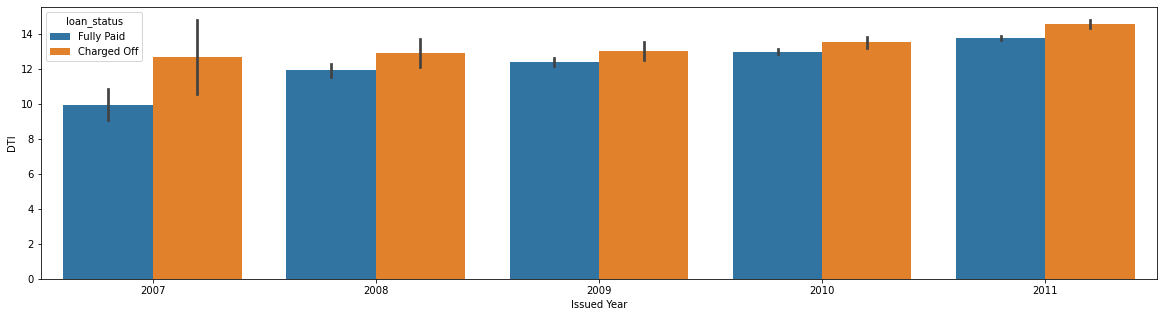

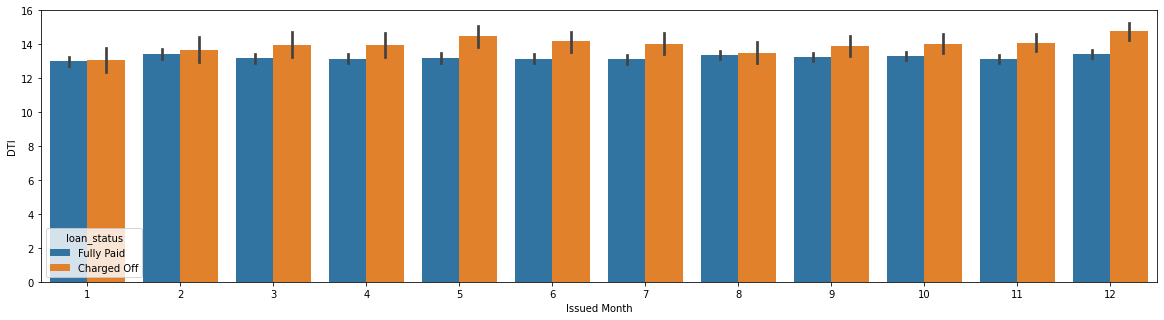

In [678]:
bar_plot_dti('issue_year', 'Issued Year', (20,5))
bar_plot_dti('issue_month', 'Issued Month', (20,5))

##### Area

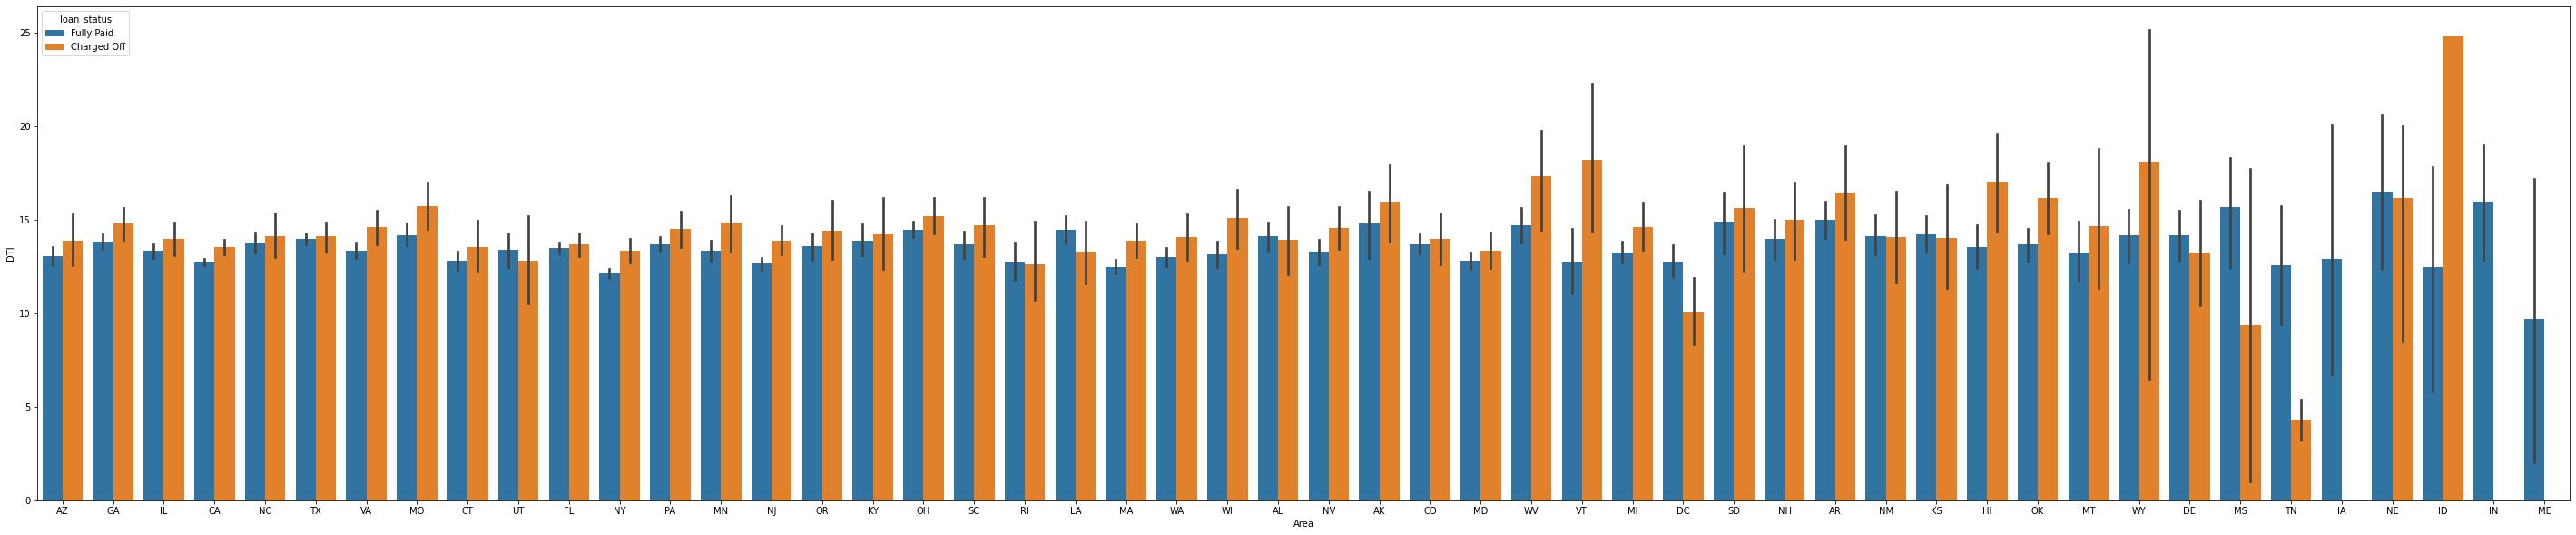

In [679]:
bar_plot_dti('addr_state', 'Area', (50,10))

### interest rate and grade

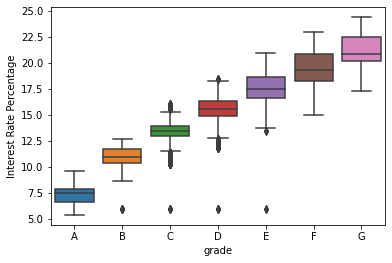

In [680]:
# relationship between interest rate and grade
sns.boxplot(y='int_rate', x='grade', data=loan, order=grade_order)
plt.ylabel('Interest Rate Percentage')
plt.show()

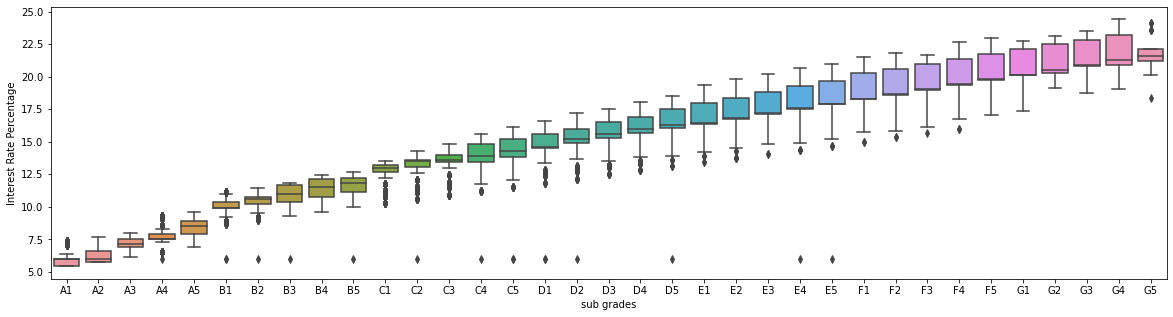

In [681]:
# relationship between interest rate and sub - grade
plt.figure(figsize=(20,5))

sns.boxplot(y='int_rate', x='sub_grade', data=loan, order=sub_grade_order)
plt.xlabel('sub grades')
plt.ylabel('Interest Rate Percentage')
plt.show()

## Segmented Univariate Analysis

### relation between purpose and loan_status

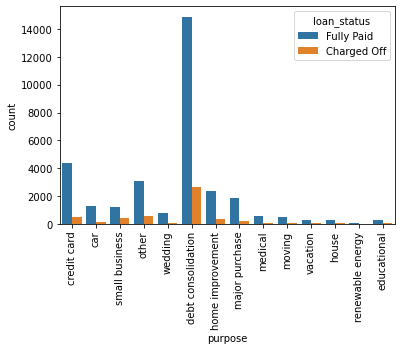

In [683]:
sns.countplot(x='purpose', hue="loan_status", data=loan)
plt.xticks(rotation=90)
plt.show()

### relation between purpose and term months

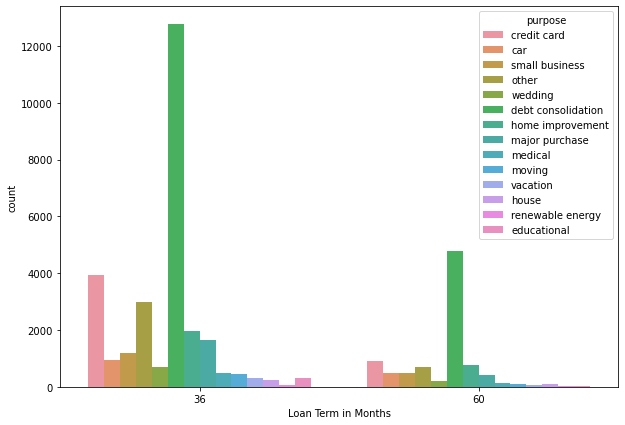

In [686]:
plt.figure(figsize=(10,7))
sns.countplot( x="term", hue='purpose', data=loan)
plt.xlabel('Loan Term in Months')
plt.show()

### relationship between purpose and loan status

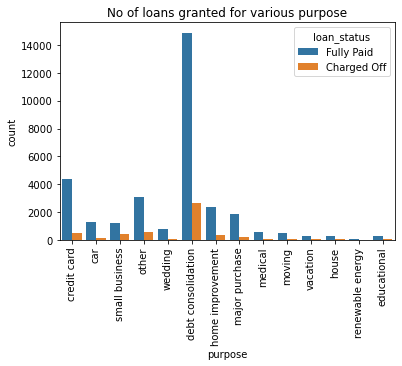

In [687]:
sns.countplot(x='purpose', hue='loan_status', data=loan)
plt.title('No of loans granted for various purpose')
plt.xticks(rotation=90)
plt.show()

### Relationship between home ownership and loan status

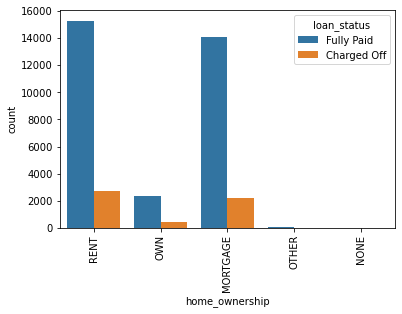

In [688]:
sns.countplot(x='home_ownership',hue='loan_status', data=loan)
plt.xticks(rotation=90)
plt.show()